<div align="center"> 
    <br><br>
<img src="https://raw.githubusercontent.com/Nikoletos-K/pyJedAI/main/documentation/pyjedai.logo.drawio.png?raw=true" alt="drawing" width="400"/>
<br><br>
</div>
<hr>
In this notebook we present the pyJedAI approach. pyJedAI is a an end-to-end and an upcoming python framework for Entity Resolution that will be a manual of the Entity Resolution. Its usages will outperform other state-of-the-art ER frameworks as it's easy-to-use and highly optimized as it is consisted from other established python libraries (i.e pandas, networkX, ..).

<!-- The bellow figure depicts pyJedAIs structure. -->
<!-- <div align="center"> 
<img src="https://github.com/Nikoletos-K/pyJedAI/blob/main/documentation/pyJedAIarchitecture.png?raw=true" alt="drawing" width="800"/>
</div> -->

# Instalation

pyJedAI is an open-source library that can be installed from PyPI.

For more: [pypi.org/project/pyjedai/](https://pypi.org/project/pyjedai/)

In [ ]:
%pip install pyjedai

# Reading the dataset - Clean-Clean ER example

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 

<div align="center">
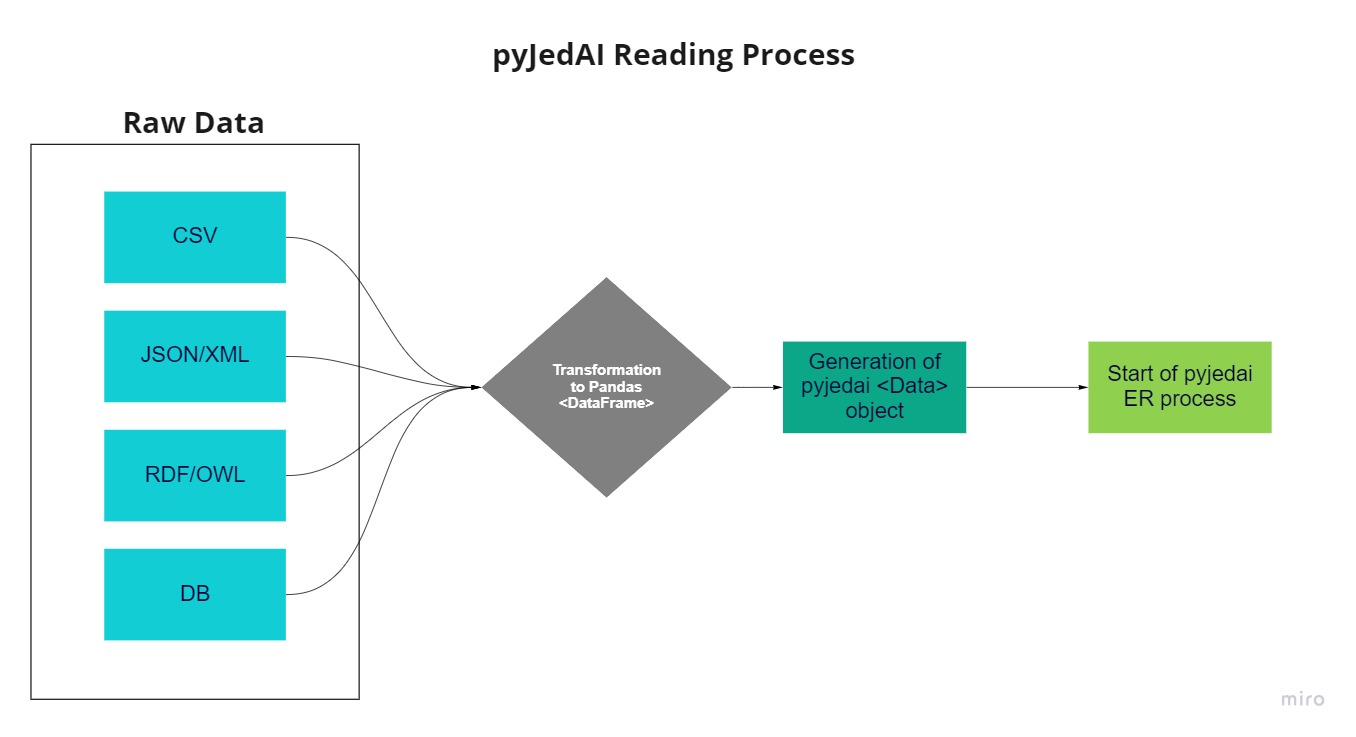
</div>

In [33]:
import pandas as pd

from pyjedai.datamodel import Data

d1 = pd.read_csv("./data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

data.process()

In [3]:
data.print_specs()

Type of Entity Resolution:  Clean-Clean
Number of entities in D1:  1076
Attributes provided  for D1:  ['id', 'name', 'description']

Number of entities in D2:  1076
Attributes provided  for D2:  ['id', 'name', 'description']

Total number of entities:  2152
Number of matching pairs in ground-truth:  1076


In [5]:
data.dataset_1.head(2)

,id,name,description,price
0,0,Sony Turntable - PSLX350H,Sony Turntable - PSLX350H/ Belt Drive System/ ...,
1,1,Bose Acoustimass 5 Series III Speaker System -...,Bose Acoustimass 5 Series III Speaker System -...,399


In [6]:
data.dataset_2.head(2)

,id,name,description,price
0,0,Linksys EtherFast EZXS88W Ethernet Switch - EZ...,Linksys EtherFast 8-Port 10/100 Switch (New/Wo...,
1,1,Linksys EtherFast EZXS55W Ethernet Switch,5 x 10/100Base-TX LAN,


In [7]:
data.ground_truth.head(2)

,D1,D2
0,206,216
1,60,46


# Creating workflow using pyJedAI methods

In [8]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import (
    StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, 
    SuffixArraysBlocking, ExtendedSuffixArraysBlocking
)
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, 
    CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, 
    ReciprocalWeightedNodePruning, ComparisonPropagation
)
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

## Workflow Architecture

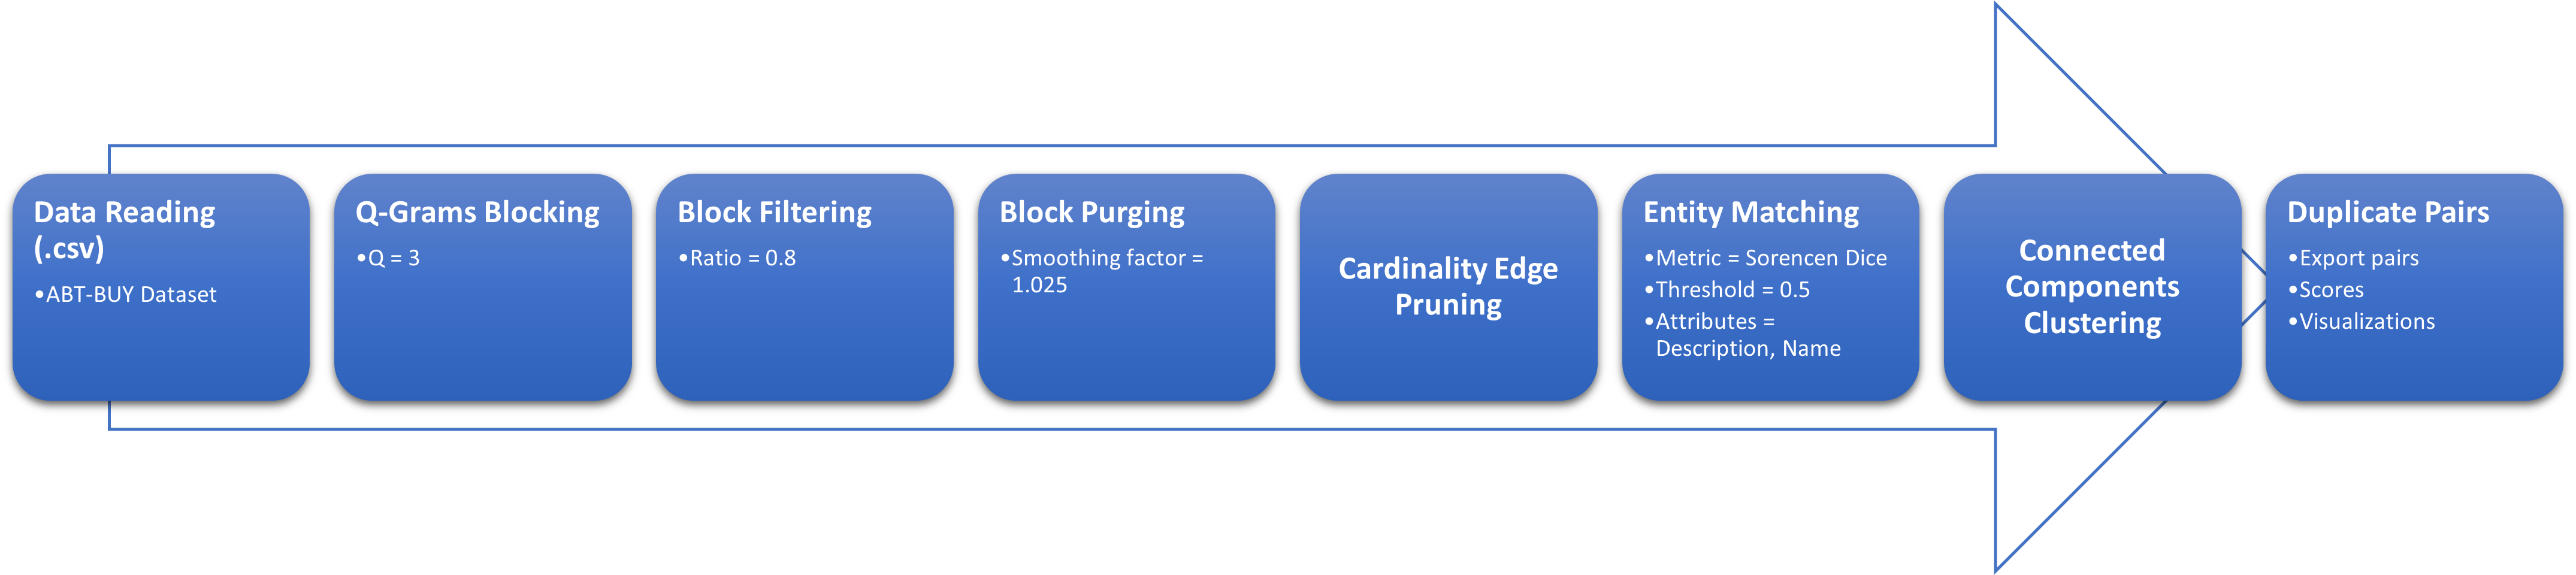

In [18]:
w = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=3)
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.8)
        ),
        dict(
            method=BlockPurging,
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
    entity_matching = dict(
        method=EntityMatching, 
        metric='sorensen_dice',
        similarity_threshold=0.5,
        attributes = ['description', 'name']
    ),
    clustering = dict(method=ConnectedComponentsClustering),
    name="Worflow-QGramsBlocking"
)

# Evaluation and detailed reporting

In [17]:
w.run(data, workflow_tqdm_enable=True, verbose=False)

Q-Grams Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

Block Filtering:   0%|                                                                           | 0/3 [00:00<…

Block Purging:   0%|          | 0/9958 [00:00<?, ?it/s]

Cardinality Edge Pruning:   0%|          | 0/1076 [00:00<?, ?it/s]

Entity Matching (sorensen_dice):   0%|          | 0/1076 [00:00<?, ?it/s]

In [11]:
w.to_df()

,Algorithm,F1,Recall,Precision,Runtime (sec),Params
0,Q-Grams Blocking,0.041641,100.000000,0.020825,0.376268,{'Q-Gramms': 3}
1,Block Filtering,0.029729,100.000000,0.014867,0.262466,{'Ratio': 0.8}
2,Block Purging,0.023116,100.000000,0.011559,0.050261,"{'Smoothing factor': 1.025, 'Max Comparisons p..."
3,Cardinality Edge Pruning,3.383632,98.884758,1.721265,3.440278,"{'Node centric': False, 'Weighting scheme': 'JS'}"
4,Entity Matching,3.383632,98.884758,1.721265,40.163827,"{'Metric': 'sorensen_dice', 'Embeddings': None..."
5,Connected Components Clustering,0.176289,99.907063,0.088222,0.009998,{}


# Visualization

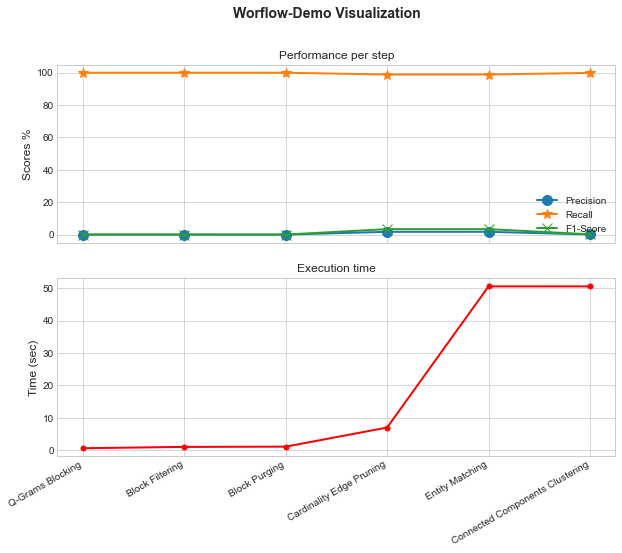

In [15]:
w.visualize()

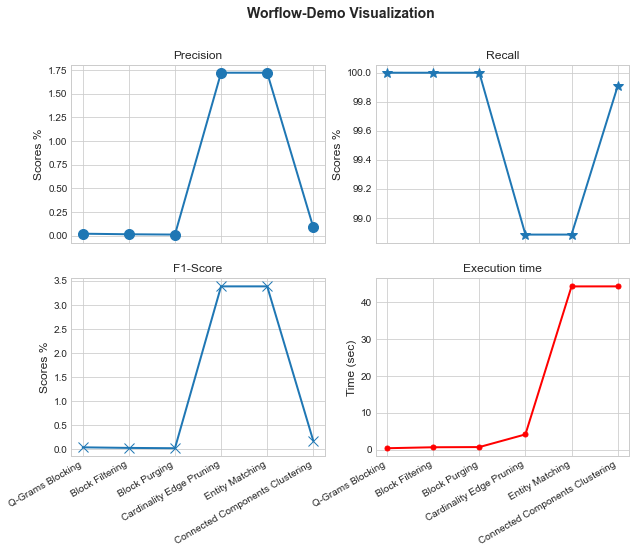

In [13]:
w.visualize(separate=True)

# Multiple workflows

pyJedAI provides methods for comparing multiple workflows. For example, we can test the above example with all the Block Building methods provided.


In [30]:
block_building_methods = [StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking]
workflows = []
for bbm in block_building_methods:
    workflows.append(WorkFlow(
        block_building = dict(
            method=bbm, 
        ),
        block_cleaning = [
            dict(
                method=BlockFiltering, 
                params=dict(ratio=0.8)
            ),
            dict(
                method=BlockPurging,
                params=dict(smoothing_factor=1.025)
            )
        ],
        comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
            method=EntityMatching,
            metric='sorensen_dice',
            similarity_threshold=0.5,
            attributes = ['description', 'name']
        ),
        clustering = dict(method=ConnectedComponentsClustering),
        name="Workflow-"+str(bbm.__name__)
    ))
    workflows[-1].run(data, workflow_tqdm_enable=True)

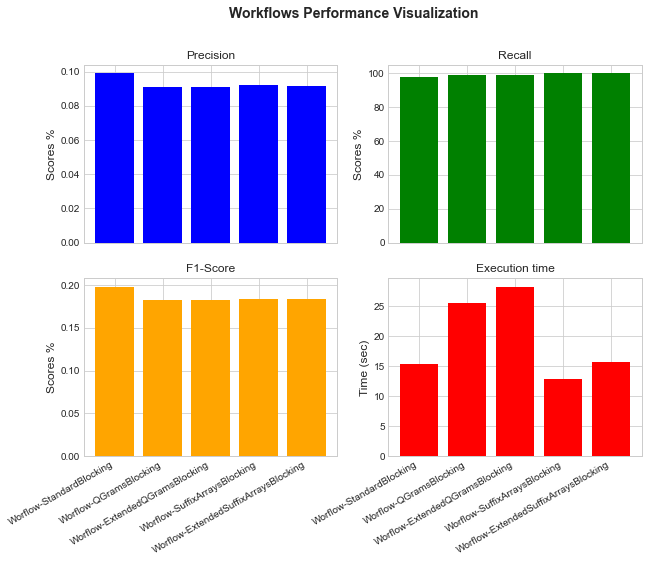

,Name,F1,Recall,Precision,Runtime (sec)
0,Worflow-StandardBlocking,0.197932,97.862454,0.099066,15.329561
1,Worflow-QGramsBlocking,0.182086,98.884758,0.091127,25.636439
2,Worflow-ExtendedQGramsBlocking,0.181989,98.791822,0.091078,28.260825
3,Worflow-SuffixArraysBlocking,0.183603,99.814126,0.091886,12.857900
4,Worflow-ExtendedSuffixArraysBlocking,0.183203,99.907063,0.091686,15.665206


In [32]:
compare_workflows(workflows, with_visualization=True)

<hr>
<div align="right">
K. Nikoletos, G. Papadakis & M. Koubarakis
</div>
<div align="right">
<a href="https://github.com/Nikoletos-K/pyJedAI/blob/main/LICENSE">Apache License 2.0</a>
</div>